In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id


from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch


from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.nips.helper import center_pclouds_in_unit_sphere

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
first_time_running = True
load_model = False
load_epoch = None
seed = 42

max_training_epochs = 1000
loss = 'chamfer'

class_name = raw_input('Give me the class type: ').lower()
syn_id = shape_net_category_to_synth_id()[class_name]

experiment_id = raw_input('Give me the experimen ID:').lower()
experiment_name = 'ae_farm_' + class_name + '_' + 'conv_arch_'+ experiment_id +'_' + str(n_pc_samples) +  'pts_' + loss


top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type: chair
Give me the experimen ID:8


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/ae_farming/ae_farm_chair_conv_arch_8_2048pts_chamfer'

In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

train_data = PointCloudDataSet(pclouds)

6778 files containing complete point clouds were found.


In [6]:
if n_pc_samples == 2048:
    encoder_args = {'n_filters': [128, 128, 256, 128],
                    'filter_sizes' :[40, 20, 10, 10],
                    'strides': [1, 2, 2, 1]}
else:
    assert(False)
    
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
    
    
else:
    n_input = [n_pc_samples, 3]

    decoder_args = {'layer_sizes': [1024, 2048, np.prod(n_input)]}

    conf = Conf(
                n_input = n_input,
                training_epochs = max_training_epochs,
                batch_size = 50,
                loss = loss,
                denoising = False,
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.0005,
                z_rotate = False, 
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                encoder_args = encoder_args,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,        
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))    
    
reset_tf_graph()
ae = PointNetAutoEncoder(experiment_name, conf)

if load_model:

    if load_epoch is None: # load last saved.
        saved_epochs = read_saved_epochs(conf.train_dir)
        load_epoch = saved_epochs[-1]
        
    ae.restore_model(conf.train_dir, load_epoch, verbose=True)

In [7]:
if do_training:
    buf_size = 1 # flush each line
    fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
    train_stats = ae.train(train_data, conf, log_file=fout)
    fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.1575', 'loss=', '0.004202752')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/ae_farming/ae_farm_chair_conv_arch_8_2048pts_chamfer/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '0.1274', 'loss=', '0.002098909')
('Epoch:', '0003', 'training time (minutes)=', '0.1229', 'loss=', '0.001785697')
('Epoch:', '0004', 'training time (minutes)=', '0.1217', 'loss=', '0.001569845')
('Epoch:', '0005', 'training time (minutes)=', '0.1352', 'loss=', '0.001435052')
('Epoch:', '0006', 'training time (minutes)=', '0.1236', 'loss=', '0.001338563')
('Epoch:', '0007', 'training time (minutes)=', '0.1229', 'loss=', '0.001250585')
('Epoch:', '0008', 'training time (minutes)=', '0.1359', 'loss=', '0.001190488')
('Epoch:', '0009', 'training time (minutes)=', '0.1243', 'loss=', '0.001127809')
('Epoch:', '0010', 'training time (minutes)=', '0.1241', 'loss=', 

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


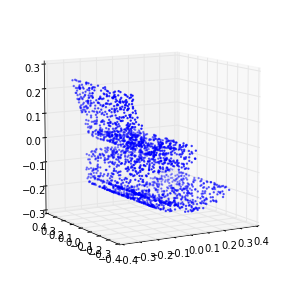

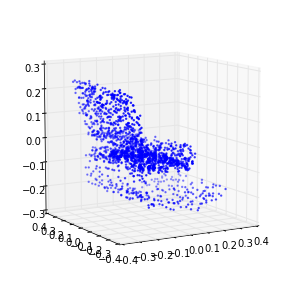

In [8]:
# Plot Some feed-reconstruction pairs.
feed = train_data.next_batch(1)[0]
rec = ae.reconstruct(feed)[0]
Point_Cloud(feed[0]).plot();
Point_Cloud(rec[0]).plot();